In [1]:
import json
import os
import pandas as pd
import networkx as nx

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter


%matplotlib inline

In [2]:
cwd = os.getcwd()

rel_path = "sample_graphs/sourcecred_sourcecred.json"
rel_path2 = "sample_graphs/sourcecred_research.json"
abs_file_path = os.path.abspath(os.path.join(cwd, '..', rel_path))
abs_file_path2 = os.path.abspath(os.path.join(cwd, '..', rel_path2))

with open(abs_file_path) as json_file:  
    data = json.load(json_file)
    
with open(abs_file_path2) as json_file:  
    data2 = json.load(json_file)

In [3]:
len(data[1]["nodes"])

5932

In [4]:
def jsonToMultiDiGraph(json):
    [compat, data] = json
    assert compat["type"] == "sourcecred/graph"
    assert compat["version"] == "0.4.0"
    
    def propertyDict(address):
        # Note: This code "happens to work" for the sourcecred/git and sourcecred/github
        # plugins. However, it is not a requirement that e.g. the third element of the address
        # is a type, so this code should not be used in production or with general user-provided
        # plugins
        plugin = address[1]
        type = address[2]
        if type == "REACTS":
            type = type + "/" + address[3]
        return {"address": tuple(address), "plugin": plugin, "type": type}

    
    nodes = data["nodes"]
    edges = data["edges"]
    g = nx.MultiDiGraph()
    for (i, n) in enumerate(nodes):
        g.add_node(i, **propertyDict(n))
    for e in edges:
        g.add_edge(e["srcIndex"], e["dstIndex"], **propertyDict(e["address"]))
    return g

In [5]:
data[1]['edges'][1]

{'address': ['sourcecred',
  'git',
  'HAS_PARENT',
  '2',
  'COMMIT',
  '00bc9a94616d867c9e66ef77bfb239e578d3569e',
  '2',
  'COMMIT',
  'f100cd02ccabdab93a502f777fdce268b88a0db5'],
 'dstIndex': 844,
 'srcIndex': 1}

In [6]:
Gs = jsonToMultiDiGraph(data)

In [7]:
Gr = jsonToMultiDiGraph(data2)

In [8]:
G = nx.disjoint_union(Gs,Gr)

In [9]:
G.edges[(0,736,0)]

{'address': ('sourcecred',
  'git',
  'HAS_PARENT',
  '2',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30',
  '2',
  'COMMIT',
  'd310561b9473ecaa0e22da3dac089ab61df2f723'),
 'plugin': 'git',
 'type': 'HAS_PARENT'}

I think it would make sense to try to structure the data in one of these formats. What you have alread isn't that far from the first one in the link below.

https://networkx.github.io/documentation/stable/reference/readwrite/json_graph.html

the fact is we'll probably want to be doing both graph generators and graph analysis with networkX 

https://networkx.github.io/documentation/stable/_downloads/networkx_reference.pdf

so it would make it a lot smoother to move between reality and R&D if the data formats matched.

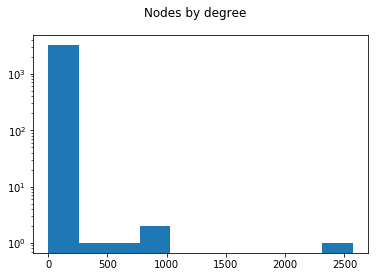

In [10]:
def nodeDegreeHistogram():
    h = nx.degree_histogram(G)
    plt.hist(h)
    plt.yscale('log')
    plt.suptitle("Nodes by degree")
    plt.show()
nodeDegreeHistogram()

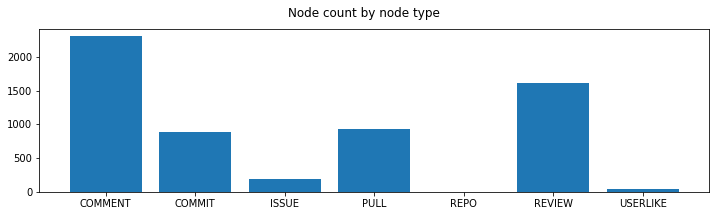

In [11]:
def nodeCountBarChart():
    node_count = Counter()
    for n in G.nodes(data=True):
        node_count[n[1]["type"]] += 1

    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(node_count.keys(), node_count.values())
    fig.suptitle('Node count by node type')
    plt.show()
nodeCountBarChart()

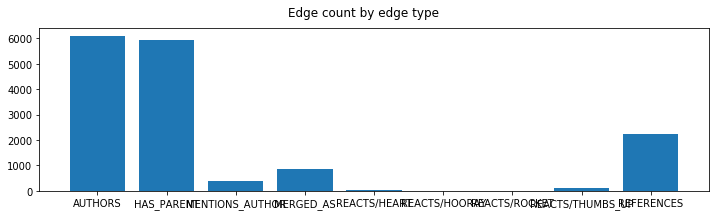

In [12]:
def edgeCountBarChart():
    edge_count = Counter()
    for e in G.edges(data=True):
        edge_count[e[2]["type"]] += 1

    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(edge_count.keys(), edge_count.values())
    fig.suptitle('Edge count by edge type')
    plt.show()
    
edgeCountBarChart()

In [13]:
len(G.edges(data=True))

15649

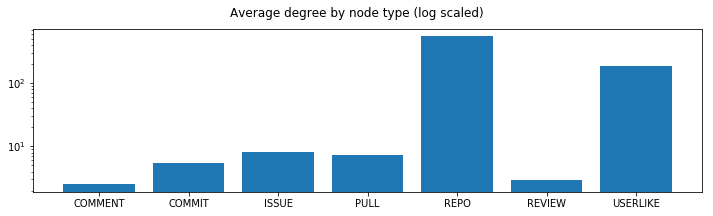

In [14]:
def nodeDegreeByTypeChart():
    type_count = Counter()
    node_type_degree = Counter()
    for n in G.nodes(data=True):
        type = n[1]["type"]
        type_count[type] += 1
        node_type_degree[type] += G.degree(n[0])
    
    average_degree = {}
    for type in type_count.keys():
        average_degree[type] = node_type_degree[type] / type_count[type]
    
    (fig, ax) = plt.subplots(figsize=(12,3))
    ax.bar(average_degree.keys(), average_degree.values())
    ax.set_yscale("log")
    fig.suptitle('Average degree by node type (log scaled)')
    plt.show()
nodeDegreeByTypeChart()

In [15]:
#drawing here is pretty lame without more attention to layout but you solve for you own positions
#this is a hybrid of random and circular because the simple algs were trivially useless
#and the complex algorithms couldn't compute in reasonable time

deg = dict(nx.degree(G))
N = len(G.nodes)



r1 = 1
t1 = 10
r2 = 400
t2 = 20
r3 = 1000

def get_pos(r, n, rv=True):
    if rv:
        rvx = np.random.rand()
        rvy = np.random.rand()
    else:
        rvx = 1
        rvy = 1
    
    return np.array([r*rvx*np.cos(2*np.pi*n/N) , r*rvy*np.sin(2*np.pi*n/N) ])

pos = {}
for n in G.nodes:
    if deg[n]<t1:
        pos[n] = get_pos(r1, n)
    elif deg[n]<t2:
        pos[n] = get_pos(r2, n)
    else :
        pos[n] = get_pos(r3, n)

#squelched to save runtime but not deleting,
#still referencing the above while working on plotting
#nx.draw(G, pos)

Nothing particularly interesting until we get the Graph objects "G" correctly labeled with all the meta data so we can use the more fun features of networkX.

Ongoing work below

In [16]:
#this is stored in a relatively intuitive way
#though I see some redundancy between the top level field
#I assuming we'll put anything we need for analysis as a top level field

G.nodes(data=True)[0]

{'address': ('sourcecred',
  'git',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30'),
 'plugin': 'git',
 'type': 'COMMIT'}

In [17]:
#inspection helper function
def getNodeAttributeUniques(g, attr):
    print(type(attr))
    return set(nx.get_node_attributes(g,attr).values())

In [18]:
node_types = set(nx.get_node_attributes(G,'type').values())
node_sources = set(nx.get_node_attributes(G,'plugin').values())

print(node_types)
cmap = plt.cm.jet
Nc = cmap.N
Nt = len(node_types)
dN = int(Nc/Nt)
cmaplist = [cmap(i*dN) for i in range(Nt)]

{'COMMIT', 'REPO', 'PULL', 'ISSUE', 'REVIEW', 'USERLIKE', 'COMMENT'}


In [19]:
getNodeAttributeUniques(G, 'plugin')

<class 'str'>


{'git', 'github'}

In [20]:
for k in ['plugin', 'type']:
    print(k)
    print(getNodeAttributeUniques(G, k))

plugin
<class 'str'>
{'github', 'git'}
type
<class 'str'>
{'COMMIT', 'REPO', 'PULL', 'ISSUE', 'REVIEW', 'USERLIKE', 'COMMENT'}


In [21]:
set([G.edges[e]['type'] for e in G.edges ])

{'AUTHORS',
 'HAS_PARENT',
 'MENTIONS_AUTHOR',
 'MERGED_AS',
 'REACTS/HEART',
 'REACTS/HOORAY',
 'REACTS/ROCKET',
 'REACTS/THUMBS_UP',
 'REFERENCES'}

In [22]:
#fair warning
#this is not a very efficient implementaiton
#took a few passes to get it working

colors = {}
bunches = {}

counter = 0
for nt in node_types:
    bunches[nt] = [x for x,y in G.nodes(data=True) if y['type']==nt]
    colors[nt]  = cmaplist[counter]
    counter = counter + 1    
    
node_color = {}
for x,y in G.nodes(data=True):
    G.nodes[x]['color'] = colors[y['type']]
    if (y['type']=="REPO") or (y['type']=="USERLIKE"):
        G.nodes[x]['label']= y['address'][4]
    else :
        G.nodes[x]['label']=y['type']
    


markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]

node_shape = {}
shapes= {}

counter = 0
for ns in node_sources:
    bunches[ns] = [x for x,y in G.nodes(data=True) if y['plugin']==ns]
    shapes[ns]  = markers[counter]
    counter = counter+1

for x,y in G.nodes(data=True):
    G.nodes[x]['shape'] = shapes[y['plugin']]

In [23]:
nx.get_node_attributes(G, 'color')[0]

(0.0, 0.0, 0.5, 1.0)

In [24]:
def inspectSubGraph(g, seed, expand=True, verbose=False, label=True,pos = "kk"):
    
    nbunch = seed
    if expand:
        for s in seed:
            nbunch = list(nx.all_neighbors(g,s))+nbunch
            
    #print(nbunch)
    sg = nx.subgraph(g,set(nbunch))
    sgc = np.array(list(nx.get_node_attributes(sg,'color').values()))
    #sgs = nx.get_node_attributes(sg,'shape')
    #print(sgc)
    #nx.draw_kamada_kawai(sg, node_color =sgc, node_shape=sgs , alpha=.5)
    
    if verbose:
        print("nodes")
        for n in sg.nodes:
            print(n)
            print(sg.nodes[n])
        
        print("")
        print("edges")
        for e in sg.edges:
            print(e)
            print(sg.edges[e])
    
    labels = None
    if label:
        labels = nx.get_node_attributes(sg, 'label')
        
    if pos == "kk":
        nx.draw_kamada_kawai(sg, node_color =sgc, node_shape = '.',alpha=.5, labels=labels, font_size=8)
    elif pos =="spring":
        nx.draw_spring(sg, node_color =sgc, node_shape = '.',alpha=.5, labels=labels, font_size=8)
    elif pos == "spectral":
        nx.draw_spectral(sg, node_color =sgc, node_shape = '.',alpha=.5, labels=labels, font_size=8)
    else:
        nx.draw_circular(sg, node_color =sgc, node_shape = '.',alpha=.5, labels=labels, font_size=8)

In [25]:
#tuples are (to_weight, from_weight)
edge_wt_by_type = {
    'AUTHORS': (0.5,1),
    'HAS_PARENT':(1,1/4),
    'MENTIONS_AUTHOR': (1,1/32),
    'MERGED_AS':(.5,1),
    'REFERENCES':(1,1/16),
    'REACTS/HEART':(2,1/32),
    'REACTS/HOORAY':(4,1/32),
    'REACTS/ROCKET':(1,0), #appears to be missing from current implementation
    'REACTS/THUMBS_UP':(1,1/32)
    }

node_wt_by_type = {
    'ISSUE':2.0, 
    'REPO':4.0, 
    'COMMENT': 1.0, 
    'COMMIT':2.0, 
    'USERLIKE':1.0, 
    'REVIEW': 1.0, 
    'PULL': 4.0
    
}

In [26]:
def edge_count(src,dst):
    i =0
    stop = False
    while not(stop):
        try:
            x = G.edges[(src,dst,i)]
            i=i+1
        except:
            stop = True
            return i

In [27]:
edge_count(0, 736)

1

In [28]:
#set up for a pagerank calculation
N = len(G.nodes)

alpha = 0
seed = {n:1.0/N for n in G.nodes}

self_loop_wt = 10**(-3)

for n in G.nodes:
    #G.nodes[n]['seed']=seed[n]
    G.nodes[n]['score'] = seed[n]

for e in G.edges:
    e_wts = edge_wt_by_type[G.edges[e]['type']]
    src_wt = node_wt_by_type[G.nodes[e[0]]['type']]
    dst_wt = node_wt_by_type[G.nodes[e[1]]['type']]
    
    G.edges[e]['in_weight'] = e_wts[0]*dst_wt
    G.edges[e]['out_weight'] = e_wts[1]*src_wt

for n in G.nodes:
    wt = self_loop_wt
    for nb in nx.all_neighbors(G,n):
        #outbound neighbor
        if nb in G.neighbors(n):
            e_count = edge_count(n,nb)
            for e3 in range(e_count):
                wt = wt + G.edges[(n,nb,e3)]['out_weight']
        #inbound neighbor
        else:
            e_count = edge_count(nb,n)
            for e3 in range(e_count):
                wt = wt + G.edges[(nb,n,e3)]['in_weight']
            
    G.nodes[n]['denominator']=wt

In [29]:
G.edges[(0, 736, 0)]

{'address': ('sourcecred',
  'git',
  'HAS_PARENT',
  '2',
  'COMMIT',
  '007cf88172d7ea9b0cdada78f124f7a41b811b30',
  '2',
  'COMMIT',
  'd310561b9473ecaa0e22da3dac089ab61df2f723'),
 'in_weight': 2.0,
 'out_weight': 0.5,
 'plugin': 'git',
 'type': 'HAS_PARENT'}

In [30]:
#out
list(G.neighbors(0))

[736, 3423]

In [31]:
list(nx.all_neighbors(G,0))

[158, 3423, 5930, 736, 3423]

In [32]:
def update_x(g):
    prior_x = nx.get_node_attributes(g,'score')
    for n in g.nodes:
        val = (self_loop_wt/g.nodes[n]['denominator']*prior_x[n] + alpha*seed[n])/(1-alpha)
        
        for nb in nx.all_neighbors(g,n):
            #outbound neighbor
            if nb in g.neighbors(n):
                e_count = edge_count(n,nb)
                for e3 in range(e_count):
                    val = val + g.edges[(n,nb,e3)]['out_weight']*prior_x[nb]/g.nodes[nb]['denominator']
            #inbound neighbor
            else:
                e_count = edge_count(nb,n)
                for e3 in range(e_count):
                    val = val + g.edges[(nb,n,e3)]['in_weight']*prior_x[nb]/g.nodes[nb]['denominator']
        g.nodes[n]['score']=val*(1-alpha)
    
    return g


In [33]:
x0 = nx.get_node_attributes(G,'score')
graph = G
K=10
x_dict = {}
for k in range(K):
    graph = update_x(graph)
    x_dict[k] = nx.get_node_attributes(graph,'score')

In [34]:
X = pd.DataFrame(x_dict).T

In [35]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,5952,5953,5954,5955,5956,5957,5958,5959,5960,5961
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.000234,0.000240,0.000237,0.000236,0.000236,0.000235,0.000234,0.000220,0.000242,0.000237,...,0.000171,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000670,0.001734,0.000783
std,0.000047,0.000051,0.000047,0.000049,0.000048,0.000049,0.000045,0.000050,0.000049,0.000049,...,0.000029,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000144,0.000247,0.000219
min,0.000115,0.000111,0.000114,0.000112,0.000113,0.000121,0.000115,0.000099,0.000116,0.000114,...,0.000142,0.000127,0.000127,0.000127,0.000127,0.000127,0.000127,0.000436,0.001374,0.000438
25%,0.000228,0.000225,0.000224,0.000231,0.000228,0.000212,0.000234,0.000203,0.000238,0.000226,...,0.000154,0.000158,0.000158,0.000158,0.000158,0.000158,0.000158,0.000609,0.001651,0.000653
50%,0.000252,0.000259,0.000254,0.000254,0.000254,0.000257,0.000247,0.000242,0.000259,0.000256,...,0.000164,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000656,0.001694,0.000764
75%,0.000263,0.000272,0.000265,0.000266,0.000264,0.000271,0.000259,0.000254,0.000271,0.000268,...,0.000177,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000710,0.001748,0.000905
max,0.000268,0.000278,0.000270,0.000271,0.000271,0.000273,0.000265,0.000258,0.000276,0.000274,...,0.000236,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000980,0.002342,0.001162


In [36]:
X.columns = ['n'+str(n) for n in X.columns]
cols = X.columns

In [37]:
X.head()

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,n5952,n5953,n5954,n5955,n5956,n5957,n5958,n5959,n5960,n5961
0,0.000115,0.000111,0.000114,0.000112,0.000113,0.000121,0.000115,0.000099,0.000116,0.000114,...,0.000236,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000980,0.002342,0.001162
1,0.000224,0.000208,0.000219,0.000228,0.000224,0.000205,0.000233,0.000197,0.000234,0.000219,...,0.000142,0.000127,0.000127,0.000127,0.000127,0.000127,0.000127,0.000436,0.001374,0.000438
2,0.000205,0.000219,0.000218,0.000199,0.000205,0.000197,0.000212,0.000184,0.000212,0.000204,...,0.000199,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000785,0.001855,0.001030
3,0.000247,0.000245,0.000240,0.000251,0.000253,0.000266,0.000238,0.000246,0.000253,0.000250,...,0.000144,0.000146,0.000146,0.000146,0.000146,0.000146,0.000146,0.000555,0.001592,0.000561
4,0.000240,0.000255,0.000253,0.000240,0.000239,0.000231,0.000246,0.000220,0.000252,0.000245,...,0.000180,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178,0.000718,0.001756,0.000922


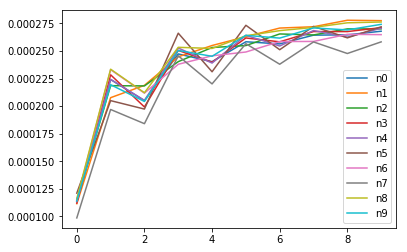

In [38]:
X[cols[:10]].plot()

(array([5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.555e+03, 1.930e+02, 3.700e+01, 4.800e+01,
        7.000e+00, 2.000e+00, 9.000e+00, 7.510e+02, 4.700e+01, 1.200e+01,
        3.000e+00, 1.210e+02, 2.100e+01, 4.500e+01, 8.010e+02, 3.500e+01,
        1.170e+02, 6.800e+01, 3.000e+00, 1.800e+01, 4.900e+01, 1.000e+01,
        2.200e+01, 2.300e+01, 7.000e+00, 3.030e+02, 1.540e+02, 9.200e+01,
        6.600e+01, 9.300e+01, 6.700e+01, 1.300e+01, 4.500e+01, 3.300e+01,
        3.000e+01, 1.500e+01, 1.500e+01, 5.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

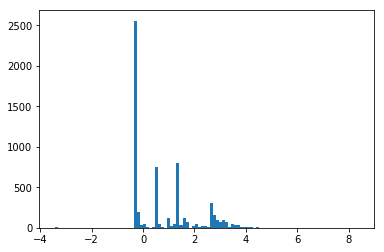

In [39]:
plt.hist([np.log(x) for x in nx.get_node_attributes(G,'denominator').values()], bins=100)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.824e+03, 8.650e+02, 6.300e+01, 6.700e+01, 1.000e+01, 6.000e+00,
        9.000e+00, 2.030e+02, 5.640e+02, 3.200e+01, 1.500e+01, 7.200e+01,
        6.700e+01, 1.600e+01, 7.370e+02, 1.120e+02, 1.190e+02, 4.300e+01,
        4.100e+01, 1.500e+01, 3.900e+01, 2.200e+01, 2.400e+01, 8.000e+00,
        2.400e+01, 7.000e+00, 3.990e+02, 5.600e+01, 1.290e+02, 2.900e+01,
        9.100e+01, 6.700e+01, 3.800e+01, 2.900e+01, 2.600e+01, 2.200e+01,
        2.200e+01, 1.300e+01, 7.000e+00, 9.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

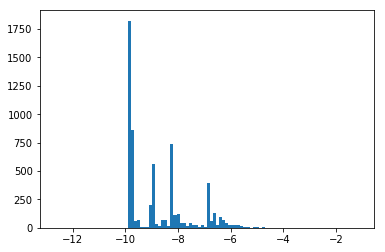

In [40]:
plt.hist([np.log(x) for x in nx.get_node_attributes(G,'score').values()], bins=100)

In [41]:
for n in G.nodes:
    G.nodes[n]['pagerank'] = graph.nodes[n]['score']

In [65]:
log_avg_pr_by_node_type = {}
avg_pr_by_node_type={}
for nt in node_types:
    sg = nx.subgraph(G, bunches[nt])
    prs = nx.get_node_attributes(sg,'pagerank')
    prs_val = np.fromiter(prs.values(), dtype=float)
    avg_pr_by_node_type[nt]= np.mean(prs_val)
    log_avg_pr_by_node_type[nt] = np.log10(np.mean(prs_val))
    

In [66]:
log_avg_pr_by_node_type

{'COMMENT': -4.14775280078342,
 'COMMIT': -3.5460480163893338,
 'ISSUE': -3.07753446481097,
 'PULL': -2.7938284219055487,
 'REPO': -0.7879335988026354,
 'REVIEW': -3.925993965849672,
 'USERLIKE': -1.8741519752811968}